In [ ]:
# prompt: connect this notebook to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install dlib opencv-python


Face 1 saved as detected_faces/face_1.jpeg
Face 2 saved as detected_faces/face_2.jpeg
Face 3 saved as detected_faces/face_3.jpeg
Face 4 saved as detected_faces/face_4.jpeg
Face 5 saved as detected_faces/face_5.jpeg
Overall Image Sharpness (Laplacian Var): 3804.00
Clear face detected: True
Processed image saved as: processed_images/test 3.jpeg


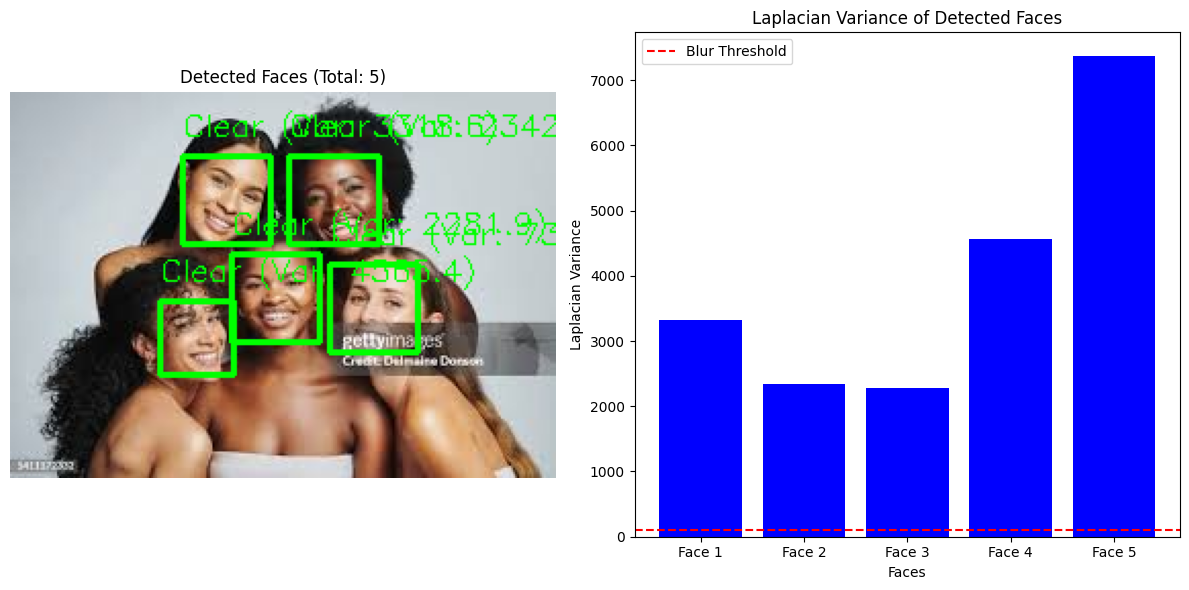

In [1]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the HOG-based face detector from dlib
hog_face_detector = dlib.get_frontal_face_detector()

# Function to detect if an image (or face region) is blurry using Laplacian variance
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # Calculate the Laplacian variance
    return laplacian_var < threshold, laplacian_var  # Return if blurry and the Laplacian variance

# Function to de-blur an image using edge-preserving filter and unsharp masking
def deblur_image(image):
    filtered = cv2.edgePreservingFilter(image, flags=1, sigma_s=60, sigma_r=0.4)  # Edge-preserving filter
    blurred = cv2.GaussianBlur(filtered, (9, 9), 10.0)  # Gaussian blur
    sharpened = cv2.addWeighted(filtered, 1.5, blurred, -0.5, 0)  # Unsharp masking
    return sharpened

# Function to crop and save detected face
def save_face_crop(face_region, face_index, output_dir="detected_faces"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    face_path = os.path.join(output_dir, f"face_{face_index}.jpeg")
    cv2.imwrite(face_path, face_region)
    print(f"Face {face_index} saved as {face_path}")

# Function to process an image
def process_image(image_path, deblur_faces=True, log_path="image_analysis_log.txt"):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image path '{image_path}' does not exist.")
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces, scores, _ = hog_face_detector.run(rgb_image, 1)

    face_laplacians = []
    face_labels = []
    is_face_detected_and_clear = False

    with open(log_path, "a") as log_file:
        log_file.write(f"\nProcessing image: {image_path}\n")

        for i, face in enumerate(faces):
            x, y, w, h = face.left(), face.top(), face.right(), face.bottom()
            face_region = image[y:h, x:w]
            blurry, laplacian_var = is_blurry(face_region)
            face_laplacians.append(laplacian_var)
            face_labels.append(f"Face {i+1}")

            # Annotate and decide on deblurring
            if blurry:
                if deblur_faces:
                    face_region_deblurred = deblur_image(face_region)
                    image[y:h, x:w] = face_region_deblurred
                cv2.rectangle(image, (x, y), (w, h), (0, 255, 255), 2)
                cv2.putText(image, f"Blurry (Var: {laplacian_var:.1f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
                log_file.write(f"Face {i+1}: Blurry (Laplacian Var: {laplacian_var:.2f})\n")
            else:
                is_face_detected_and_clear = True
                cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
                cv2.putText(image, f"Clear (Var: {laplacian_var:.1f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                log_file.write(f"Face {i+1}: Clear (Laplacian Var: {laplacian_var:.2f})\n")

            save_face_crop(face_region, i+1)

        # Calculate overall sharpness of the image
        _, overall_sharpness = is_blurry(image)
        log_file.write(f"Overall Image Sharpness (Laplacian Var): {overall_sharpness:.2f}\n")
        print(f"Overall Image Sharpness (Laplacian Var): {overall_sharpness:.2f}")

        if is_face_detected_and_clear:
            print("Clear face detected: True")
            log_file.write("Clear face detected: True\n")
        else:
            print("Clear face detected: False")
            log_file.write("Clear face detected: False\n")

    # Save annotated image
    output_path = os.path.join("processed_images", os.path.basename(image_path))
    os.makedirs("processed_images", exist_ok=True)
    cv2.imwrite(output_path, image)
    print(f"Processed image saved as: {output_path}")

    # Display results with graphs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Detected Faces (Total: {len(faces)})")

    plt.subplot(1, 2, 2)
    plt.bar(face_labels, face_laplacians, color='blue')
    plt.axhline(y=100.0, color='red', linestyle='--', label="Blur Threshold")
    plt.xlabel("Faces")
    plt.ylabel("Laplacian Variance")
    plt.title("Laplacian Variance of Detected Faces")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Batch processing for a directory of images
def batch_process_images(image_dir, deblur_faces=True):
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory '{image_dir}' does not exist.")

    for image_filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_filename)
        if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Processing {image_filename}...")
            process_image(image_path, deblur_faces=deblur_faces)

# Example of processing a single image
image_path = "/content/test 3.jpeg"  # Replace with your image path
process_image(image_path, deblur_faces=True)

# Example of processing multiple images in a directory
# Uncomment the lines below to process a batch of images

# image_dir = "/path/to/your/image_directory"  # Replace with your directory path
# batch_process_images(image_dir, deblur_faces=True)
